## Download code and setup

In [ ]:
!git clone https://github.com/mli0603/stereo-transformer

In [ ]:
#!g1.1:bash
ls

In [27]:
#!c1.8
import os
os.chdir('..')

### install dependencies

In [ ]:
#!c1.8
%pip install -r requirements.txt
%pip install gdown

### get pretrained model

In [31]:
#!c1.8
import gdown
url = 'https://drive.google.com/uc?id=1UUESCCnOsb7TqzwYMkVV3d23k8shxNcE'
gdown.download(url,'kitti_finetuned_model.pth.tar',quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1UUESCCnOsb7TqzwYMkVV3d23k8shxNcE
To: /home/jupyter/work/resources/stereo-transformer/kitti_finetuned_model.pth.tar
30.4MB [00:00, 65.0MB/s]


'kitti_finetuned_model.pth.tar'

### verify gpu is configured correctly

In [32]:
#!c1.8
import torch
if not torch.cuda.is_available():
    print('GPU not available.')

GPU not available.


### import dependencies

In [33]:
#!c1.8
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt

from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor

## Inference

### Define STTR model

In [34]:
#!c1.8
# Default parameters
args = type('', (), {})() # create empty args
args.channel_dim = 128
args.position_encoding='sine1d_rel'
args.num_attn_layers=6
args.nheads=8
args.regression_head='ot'
args.context_adjustment_layer='cal'
args.cal_num_blocks=8
args.cal_feat_dim=16
args.cal_expansion_ratio=4

In [35]:
#!c1.8
# model = STTR(args).cuda().eval()
model = STTR(args).eval()

In [39]:
#!c1.8
# Load the pretrained model
model_file_name = "kitti_finetuned_model.pth.tar"
checkpoint = torch.load(model_file_name, map_location=torch.device('cpu'))
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict)
print("Pre-trained model successfully loaded.")

Pre-trained model successfully loaded.


### Read image

In [177]:
#!c1.8
left = np.array(Image.open('sample_data/KITTI_2015/training/image_2/000046_10.png'))
right = np.array(Image.open('sample_data/KITTI_2015/training/image_3/000046_10.png'))
disp = np.array(Image.open('sample_data/KITTI_2015/training/disp_occ_0/000046_10.png')).astype(np.float) / 256.

# left = np.array(Image.open('sample_data/SCENE_FLOW/RGB_cleanpass/left/A-0032-0006.png'))
# right = np.array(Image.open('sample_data/SCENE_FLOW/RGB_cleanpass/right/A-0032-0006.png'))
# disp = np.array(Image.open('sample_data/SCENE_FLOW/disparity/left/A-0032-0006.pfm')).astype(np.float) / 256.

# left = np.array(Image.open('sample_data/my/left.png'))
# right = np.array(Image.open('sample_data/my/right.png'))
# disp = np.array(Image.open('sample_data/KITTI_2015/training/disp_occ_0/000046_10.png')).astype(np.float) / 256.

In [178]:
#!c1.8
import cv2
# left = cv2.resize(left, (left.shape[1] // 2, left.shape[0] // 2), cv2.INTER_CUBIC)
# right = cv2.resize(right, (right.shape[1] // 2, right.shape[0] // 2), cv2.INTER_CUBIC)
# disp = cv2.resize(disp, (disp.shape[1] // 2, disp.shape[0] // 2), cv2.INTER_CUBIC)

# left = left[::3, ::3, :]
# right = right[::3, ::3, :]
# disp = disp[::3, ::3]

left = left[:, 1000:1200, :]
right = right[:, 1000:1200, :]
disp = disp[:, 1000:1200]

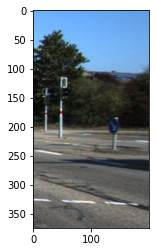

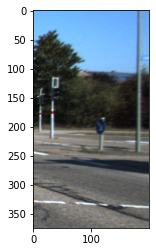

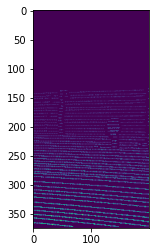

In [179]:
#!c1.8
# Visualize image
plt.figure(1)
plt.imshow(left)
plt.figure(2)
plt.imshow(right)
plt.figure(3)
plt.imshow(disp)

### Preprocessing

In [172]:
#!c1.8
# normalize
input_data = {'left': left, 'right':right, 'disp':disp}
# input_data = {'left': left[..., :3], 'right': right[..., :3]}
input_data = normalization(**input_data)

In [180]:
#!c1.8
# donwsample attention by stride of 3
h, w, _ = left.shape
bs = 1

downsample = 3
col_offset = int(downsample / 2)
row_offset = int(downsample / 2)
sampled_cols = torch.arange(col_offset, w, downsample)[None,].expand(bs, -1)#.cuda()
sampled_rows = torch.arange(row_offset, h, downsample)[None,].expand(bs, -1)#.cuda()

In [181]:
#!c1.8
# build NestedTensor
# input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)
input_data = NestedTensor(input_data['left'][None,],input_data['right'][None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)

TypeError: 'NestedTensor' object is not subscriptable

### inference

In [175]:
#!c1.8
output = model(input_data)

In [176]:
#!c1.8
# set disparity of occ area to 0
disp_pred = output['disp_pred'].data.cpu().numpy()[0]
occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_pred[occ_pred] = 0.0

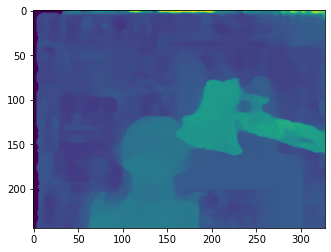

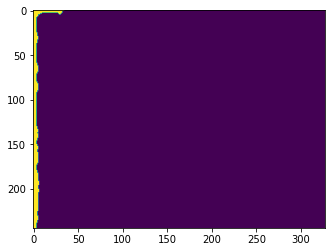

In [166]:
#!c1.8
# visualize predicted disparity and occlusion map
plt.figure(4)
plt.imshow(disp_pred)
plt.figure(5)
plt.imshow(occ_pred)

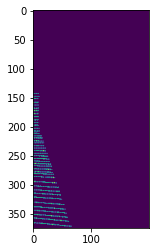

In [148]:
#!c1.8
# manually compute occluded region
occ_mask = compute_left_occ_region(w, disp)

# visualize the known occluded region
plt.figure(6)
plt.imshow(occ_mask)

In [149]:
#!c1.8
# compute difference in non-occluded region only
diff = disp - disp_pred
diff[occ_mask] = 0.0 # set occ area to be 0.0

# Note: code for computing the metrics can be found in module/loss.py
valid_mask = np.logical_and(disp > 0.0, ~occ_mask)

# find 3 px error
err_px = (diff > 3).sum()
total_px = (valid_mask).sum()
print('3 px error %.3f%%'%(err_px*100.0/total_px))

# find epe
err = np.abs(diff[valid_mask]).sum()
print('EPE %f'%(err * 1.0/ total_px))

3 px error 0.488%
EPE 0.776137
